In [1]:
import ROOT
import uproot
import matplotlib.pyplot as plt
import numpy as np
import awkward as ak

from sklearn.preprocessing import normalize as norm

Welcome to JupyROOT 6.30/04


(-2000.0, -1400.0)

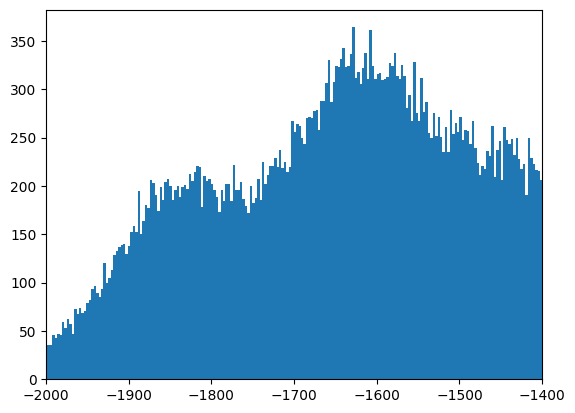

In [54]:
def load_histo(dat_PATH):
    data = np.loadtxt(dat_PATH, skiprows=0, comments='==')
    noises_edges = np.zeros((int(data.shape[0]/2), data.shape[1]))       #np.array([[]] * int(data.shape[0]/2))
    noises_values = np.zeros((int(data.shape[0]/2), data.shape[1]))       #np.array([[]] * int(data.shape[0]/2))

    for i in range(int(data.shape[0]/2)):
        noises_edges[i] = (data[2 * i])
        noises_values[i] = (data[2 * i + 1])

    return noises_edges, noises_values

edge_N, bin_N = load_histo("../Dati/Run_Co_3000_50_ChargeHistos_5_27_2024.dat")

channel = 12


    
edge_N = edge_N[channel]
bin_N = bin_N[channel]




centers_N = np.convolve(edge_N, [0.5, 0.5], "valid")
err_N = np.sqrt(bin_N)
plt.bar(centers_N, bin_N[:-1], width=centers_N[1]-centers_N[0])
plt.xlim(-2000, -1400)



In [54]:
FILE_PATH = "../Dati/Run_Co_correlations_Data_5_23_2024_Ascii_0000.root" #Relative file path
file = uproot.open(FILE_PATH)
file["tree"].show()


baselines = np.array(file["tree"]["base"].array()[1:-1]) 
charges = np.array(file["tree"]["charge"].array()[1:-1])
amp = np.array(file["tree"]["amp"].array()[1:-1])
lead_edge = np.array(file["tree"]["letime"].array()[1:-1])
t_edge = np.array(file["tree"]["tetime"].array()[1:-1])
channel= np.array(file["tree"]["ch"].array()[1:-1])
waveform = np.array(file["tree"]["pshape"].array()[1:-1])
flag    = np.array(file["tree"]["Flag"].array()[1:-1])



name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
ev                   | int32_t                  | AsDtype('>i4')
nch                  | int32_t                  | AsDtype('>i4')
ch                   | int32_t[]                | AsJagged(AsDtype('>i4'))
base                 | float[]                  | AsJagged(AsDtype('>f4'))
amp                  | float[]                  | AsJagged(AsDtype('>f4'))
charge               | float[]                  | AsJagged(AsDtype('>f4'))
letime               | float[]                  | AsJagged(AsDtype('>f4'))
tetime               | float[]                  | AsJagged(AsDtype('>f4'))
Flag                 | int32_t[2]               | AsDtype("('>i4', (2,))")
pshape               | float[][1024]            | AsJagged(AsDtype("('>f4', (...


In [167]:
print(waveform[0][7])

[-0.000628 -0.000153 -0.000731 ... -0.047299 -0.052765 -0.064867]


In [3]:
print(flag)

[[ 7  8]
 [ 9 12]
 [ 5  9]
 ...
 [ 5 15]
 [ 9 10]
 [ 0  5]]


In [55]:

N_ch= len(charges[0])
N_ev=len(charges)
print(N_ev, N_ch)

7452 16


(157, 2)


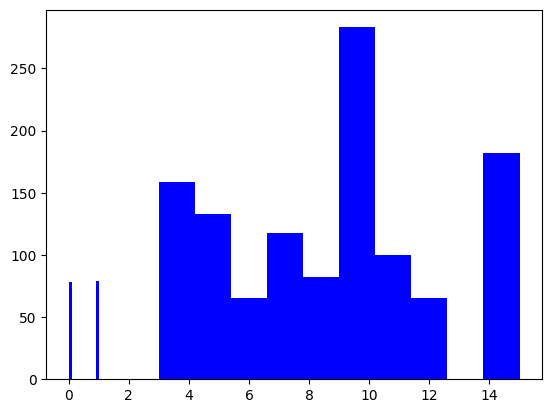

In [46]:
#posso controllare come un canale è accoppiato agli altri
ch=2
msk=np.where(flag[:,0]== ch)[0]
plt.hist(flag[msk, 1],color = "blue")
msk=np.where(flag[:,1]== ch)[0]
plt.hist(flag[msk, 0],color="blue")

print(flag[msk, :].shape)

#

ad ogni event è associata una flag, ora devo selezionare tutti gli event con una stessa flag

In [56]:
def timing_measurement(paired_wf_1, sampling, shiftR, shiftL, n_mean, thresh):
    wf_1_len = len(paired_wf_1)
    new_wf_1 = np.array(paired_wf_1).reshape([np.array(paired_wf_1).shape[0], 1, np.array(paired_wf_1).shape[1]])

    for evt in range(new_wf_1.shape[0]):
        for ch in range(new_wf_1.shape[1]):
            bsl_1 = new_wf_1[evt, ch, 0:32].mean()
            new_wf_1[evt, ch, :] = np.convolve(new_wf_1[evt, ch], [1/n_mean] * n_mean, mode = "same") - bsl_1

    new_wf_1 = -norm(-new_wf_1.reshape(-1, 1024), norm = "max", axis = 1, copy = True, return_norm = False)
    threshold = thresh

    ledges1 = np.zeros(new_wf_1.shape[0])

    for evt in range(new_wf_1.shape[0]):
        try:
            ledge= np.where(np.diff(np.sign(new_wf_1[evt] - threshold)))[0][0]
            coef = np.polyfit(new_wf_1[evt][ledge-shiftL:ledge+shiftR],np.arange(ledge-shiftL, ledge+shiftR),1)
            ledges1[evt] = np.poly1d(coef)(threshold) 
        except IndexError:
            continue

    return ledges1*sampling

In [57]:
#data una coppia e un dataset la funzione ritorna l'offset relativo alla misura di timing
def offset_and_resolution_estimation( couple, flag, waveform, sampling, shiftR, shiftL, n_mean, thresh):
    idx=np.where( (flag[:,0]==couple[0] ) & (flag[:,1]==couple[1]) )[0]
    if(len(idx)>0):
        paired_wf_1=waveform[idx][:,couple[0]]
        paired_wf_2=waveform[idx][:,couple[1]]
        timeres=timing_measurement(paired_wf_1, sampling, shiftR, shiftL, n_mean, thresh)-timing_measurement(paired_wf_2, sampling, shiftR, shiftL, n_mean, thresh)
        msk=np.where(np.abs(timeres) < 50)[0]
        return(np.mean(timeres[msk]), np.std(timeres[msk]), timeres)
    else:
        return(0,0,0)


In [58]:
offset_matrix=np.zeros((N_ch, N_ch))
def offset_matrix_filling(N_ch, flag, waveform, sampling, shiftR, shiftL, n_mean, thresh):
    for i in range(N_ch):
        for j in range(N_ch):
            tmp=offset_and_resolution_estimation([i,j], flag, waveform, sampling, shiftR, shiftL, n_mean, thresh)[0]
            offset_matrix[i][j]=tmp
    return(offset_matrix)



In [80]:
sampling=2.5
shiftR=2
shiftL=0
n_mean=8
thresh=-0.1
print(offset_and_resolution_estimation([5,5], flag, waveform, sampling, shiftR, shiftL, n_mean, thresh)[0])

0


In [81]:
offset_matrix=offset_matrix_filling(N_ch, flag, waveform, sampling, shiftR, shiftL, n_mean, thresh)
print(offset_matrix)

[[ 0.          1.50500943  7.62525845  4.61293362  3.15892701  0.42782056
   4.49672154  1.77843779  2.40697245  0.59281318 -0.90675317  1.68751028
   5.71198922  0.          4.56768762  0.97792598]
 [ 0.          0.          6.11065928  2.85206175  1.13653755 -2.20474312
   2.46788101  0.51116414  0.80656163 -0.85936461 -2.18658085 -1.00696636
   3.23813492  0.          3.03523668 -0.19754189]
 [ 0.          0.          0.         -3.3739286  -5.72502314 -8.24391322
  -3.54354023 -6.27318018 -4.97360872 -7.1802282  -8.55086201 -6.64136498
  -2.35827787  0.         -3.72766191 -6.57743136]
 [ 0.          0.          0.          0.         -1.37643551 -4.76837872
   0.20964947 -2.70117638 -2.30973294 -4.06801263 -5.26312062 -2.77706457
   1.03675632  0.         -0.21015299 -3.23818714]
 [ 0.          0.          0.          0.          0.         -3.05462833
   1.55270473 -1.13492494 -1.03074154 -2.32552449 -3.62794031 -1.61582009
   2.22239742  0.          1.26570009 -1.43924862]
 [ 0.

Text(0, 0.5, 'channel')

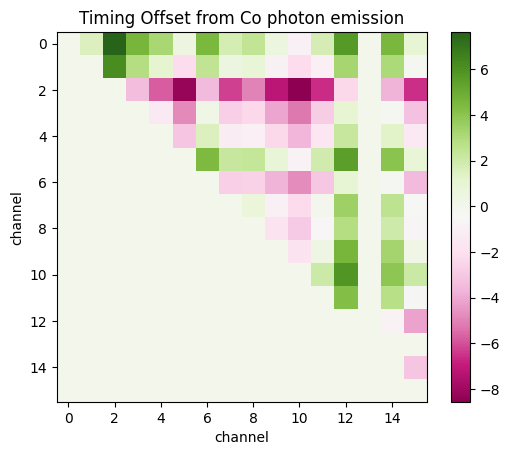

In [82]:
plt.imshow(offset_matrix, cmap='PiYG')
plt.title("Timing Offset from Co photon emission")
plt.colorbar()
plt.xlabel("channel")
plt.ylabel("channel")

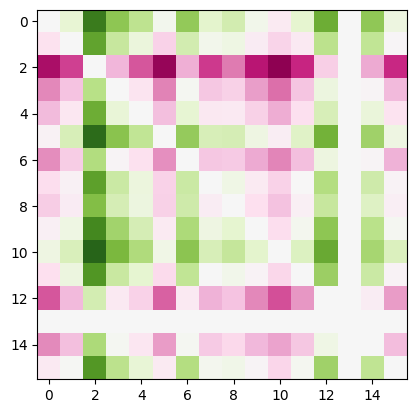

In [74]:
for i in range(N_ch):
    for j in range(i):
        offset_matrix[i][j]=-offset_matrix[j][i]

plt.imshow(offset_matrix, cmap='PiYG')

In [72]:
def save_matrix(filename, offset_matrix):
    np.savez(filename, offset_matrix)

def load_matrix(filename):
    return(np.load(filename))

save_matrix('offset_matrix.npz', offset_matrix)
loaded=load_matrix('offset_matrix.npz')
print(loaded.files)
matrix_loaded = loaded['arr_0']
print(matrix_loaded)


['arr_0']
[[ 0.          1.50500943  7.62525845  4.61293362  3.15892701  0.42782056
   4.49672154  1.77843779  2.40697245  0.59281318 -0.90675317  1.68751028
   5.71198922  0.          4.56768762  0.97792598]
 [ 0.          0.          6.11065928  2.85206175  1.13653755 -2.20474312
   2.46788101  0.51116414  0.80656163 -0.85936461 -2.18658085 -1.00696636
   3.23813492  0.          3.03523668 -0.19754189]
 [ 0.          0.          0.         -3.3739286  -5.72502314 -8.24391322
  -3.54354023 -6.27318018 -4.97360872 -7.1802282  -8.55086201 -6.64136498
  -2.35827787  0.         -3.72766191 -6.57743136]
 [ 0.          0.          0.          0.         -1.37643551 -4.76837872
   0.20964947 -2.70117638 -2.30973294 -4.06801263 -5.26312062 -2.77706457
   1.03675632  0.         -0.21015299 -3.23818714]
 [ 0.          0.          0.          0.          0.         -3.05462833
   1.55270473 -1.13492494 -1.03074154 -2.32552449 -3.62794031 -1.61582009
   2.22239742  0.          1.26570009 -1.43924